# Random Forest


Esta es una potente técnica supervisada con fines predictivos resultado de aplicar bagging a árboles de regresión. Consiste en hacer crecer árboles con mucha profundidad con dos modificaciones:
* Se generan B submuestreos de árboles con reposición de las observaciones del dataset original
* Se realiza el submuestreo sin reposición de k < n de las n variables originales para cada corte de cada árbol de cada una de las B iteraciones.

Los dos hiperparámetros más importantes para este algoritmo son la cantidad de iteraciones B (a mayor valor de B, mejor es el resultado) y la cantidad de variables k a ser utilizadas en cada corte del árbol (con k similar a la raiz de n se tienen buenos resultados).

En este notebook se utilizará Random Forest para realizar predicciones sobre la especie de pingüinos utilizando el dataset de palmer penguins. Esta técnica es muy útil en aplicaciones de clasificación y se espera que sea capaz de predecir con precisión la especie a partir de las variables del conjunto de datos.



In [63]:
#importamos los paquetes a utilizar
import seaborn as sns
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#cargamos el dataset
pinguinos = load_penguins()

La primer tarea a realizar es la limpieza y visualización del contenido del dataset.

In [64]:
#Veamos los nombres de las columnas y la fora de los datos que estos contienen
print(pinguinos.columns.values)
pinguinos.head()

['species' 'island' 'bill_length_mm' 'bill_depth_mm' 'flipper_length_mm'
 'body_mass_g' 'sex' 'year']


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Realizamos una rápida visualización del conteo de pinguinos por especie.

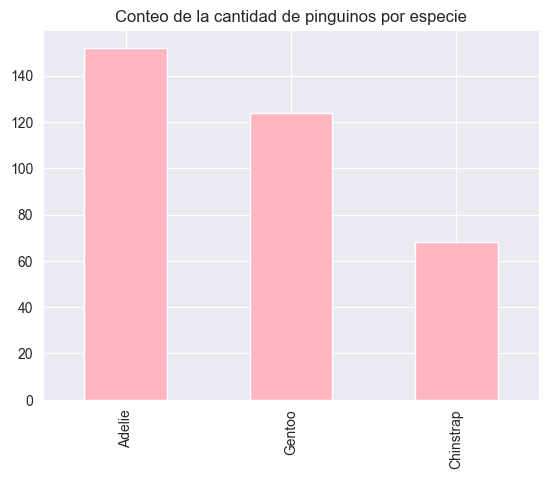

In [65]:
chart = pinguinos['species'].value_counts().plot(kind='bar', color = 'lightpink')
chart.set_title("Conteo de la cantidad de pinguinos por especie")
plt.show()

La especie que posee más individuos en el dataset es la Adelie, seguida luego por la Gentoo y Chinstrap.
Antes de realizar la limpieza del dataset se modificarán los nombres de las columnas y los valores de la columna sex y species para que se encuentren escritos en español. Los posibles valores de sexo son female y male y para el caso de especies estos son tres: Adelie, Chinstrap y Gentoo.

In [66]:
#modifico el nombre de las columnas
pinguinos = pinguinos.rename(columns={'species':'especies',
                  'island':'isla',
                  'bill_length_mm':'largo_pico', 'bill_depth_mm':'ancho_pico', 'flipper_length_mm':'largo_aleta', 'body_mass_g':'peso',
                   'sex':'sexo',
                   'year':'año'})

#modifico el nombre de los valores a traducir en las filas
row_names = {'female':'hembra',
             'male':'macho'}
pinguinos['sexo'] = pinguinos['sexo'].map(row_names)

row_names2 = {'Adelie':'Adelia',
             'Chinstrap':'Barbijo',
              'Gentoo': 'Juanito' }
pinguinos['especies'] = pinguinos['especies'].map(row_names2)

pinguinos.head()

,especies,isla,largo_pico,ancho_pico,largo_aleta,peso,sexo,año
0,Adelia,Torgersen,39.1,18.7,181.0,3750.0,macho,2007
1,Adelia,Torgersen,39.5,17.4,186.0,3800.0,hembra,2007
2,Adelia,Torgersen,40.3,18.0,195.0,3250.0,hembra,2007
3,Adelia,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelia,Torgersen,36.7,19.3,193.0,3450.0,hembra,2007


Ahora que ya tenemos la tabla traducida vamos a ver cuantos datos nulos hay en la tabla

In [67]:
pinguinos.isnull().sum()

especies        0
isla            0
largo_pico      2
ancho_pico      2
largo_aleta     2
peso            2
sexo           11
año             0
dtype: int64

In [68]:
# como son pocos los valores en relación con la cantidad total de datos en la tabla vamos a proceder completándolos con un fowardfill
pinguinos.fillna(method = 'ffill', inplace = True)

# chequeamos que ahora no haya valores faltantes
pinguinos.isnull().sum()

especies       0
isla           0
largo_pico     0
ancho_pico     0
largo_aleta    0
peso           0
sexo           0
año            0
dtype: int64

Al ya estar taotalmente completa la base de datos vamos a realizar un pairplot para observar como se relacionan las variables

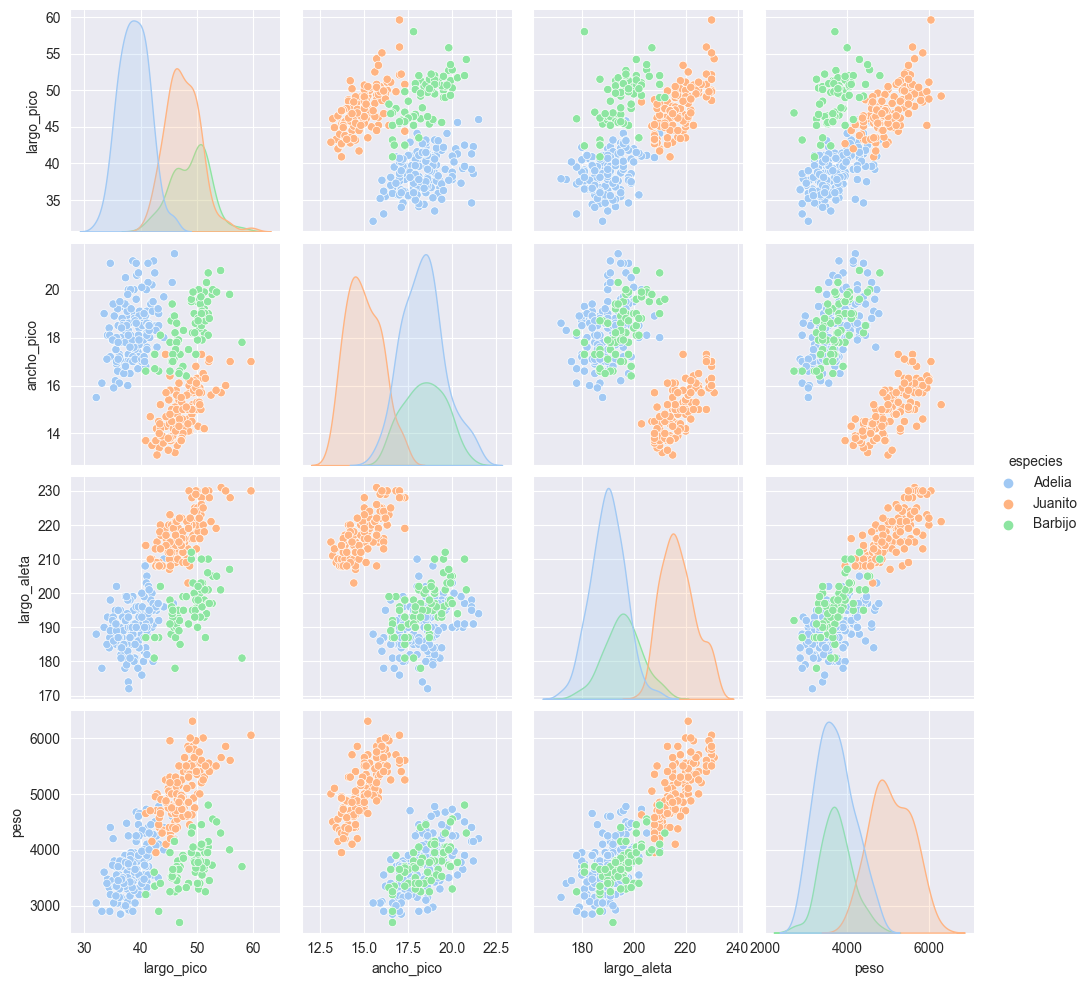

In [69]:
sns.pairplot(pinguinos.drop(['año'],axis = 1),hue='especies', palette= 'pastel')
plt.show()

Algunas cosas que se pueden observar es que el largo de la aleta y el peso parecen tener una fuerte correlación positiva. El peso también parece tener correlación positiva con el largo del pico al igual que el largo de la aleta y el largo del pico entre sí. Es interesante señalar que en el caso del ancho del pico en relación al peso se pueden observar dos clusters bien separados con los datos de los pinguinos Juanito en uno y las especies Adelia y Barbijo en el otro.

In [70]:
# Visualizamos una tabla con las correlaciones entre las variables
pinguinos.corr(numeric_only=True)

,largo_pico,ancho_pico,largo_aleta,peso,año
largo_pico,1.000000,-0.237563,0.656864,0.596365,0.058760
ancho_pico,-0.237563,1.000000,-0.585477,-0.474244,-0.067414
largo_aleta,0.656864,-0.585477,1.000000,0.870961,0.173444
peso,0.596365,-0.474244,0.870961,1.000000,0.049357
año,0.058760,-0.067414,0.173444,0.049357,1.000000


In [71]:
#Creamos una tabla con valores descriptivos del dataset
pinguinos.describe(include='all')

,especies,isla,largo_pico,ancho_pico,largo_aleta,peso,sexo,año
count,344,344,344.00000,344.000000,344.000000,344.000000,344,344.000000
unique,3,3,NaN,NaN,NaN,NaN,2,NaN
top,Adelia,Biscoe,NaN,NaN,NaN,NaN,macho,NaN
freq,152,168,NaN,NaN,NaN,NaN,177,NaN
mean,NaN,NaN,43.92093,17.143605,200.936047,4201.090116,NaN,2008.029070
std,NaN,NaN,5.45003,1.978342,14.042064,802.213531,NaN,0.818356
min,NaN,NaN,32.10000,13.100000,172.000000,2700.000000,NaN,2007.000000
25%,NaN,NaN,39.27500,15.575000,190.000000,3550.000000,NaN,2007.000000
50%,NaN,NaN,44.45000,17.300000,197.000000,4050.000000,NaN,2008.000000
75%,NaN,NaN,48.50000,18.700000,213.250000,4756.250000,NaN,2009.000000


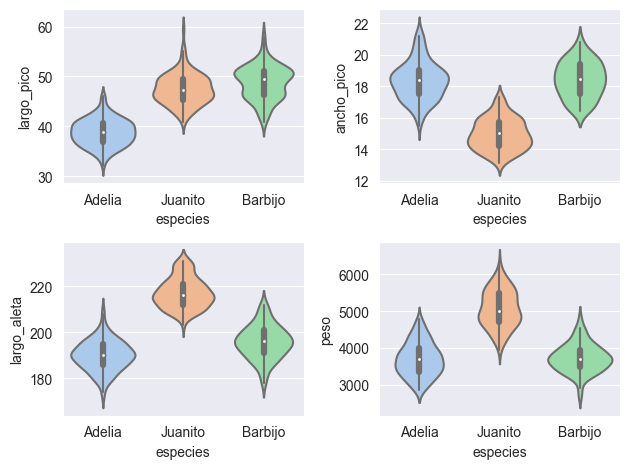

In [72]:
#Creamos cuatro plots para observar la distribución de ciertas medidas para cada especie de pinguinos.
fig, ax = plt.subplots(nrows=2, ncols=2)

plt.subplot(2, 2, 1)
sns.violinplot(data = pinguinos, x='especies', y='largo_pico', size=8,palette='pastel')

plt.subplot(2, 2, 2)
sns.violinplot(data = pinguinos, x='especies', y='ancho_pico', size=8,palette='pastel')

plt.subplot(2, 2, 3)
sns.violinplot(data = pinguinos, x='especies', y='largo_aleta', size=8,palette='pastel')

plt.subplot(2, 2, 4)
sns.violinplot(data = pinguinos, x='especies', y='peso', size=8,palette='pastel')

plt.tight_layout()

plt.show()

Observamos que la especie Juanito es la que posee las aletas más largas ademas de ser la mas pesada. Los pinguinos Adelia son los que poseen las aletas y el pico mas cortos pero el ancho de su pico es superior al de las otras especies.

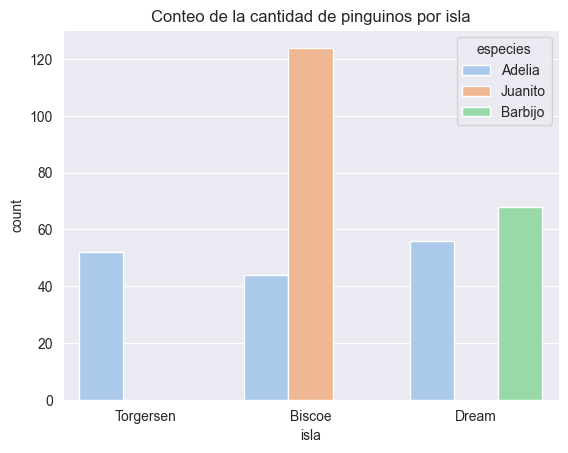

In [73]:
chart = sns.countplot(pinguinos, x ='isla',hue='especies', palette='pastel')
chart.set_title('Conteo de la cantidad de pinguinos por isla')
plt.show()

La isla con mayor cantidad de pinguinos es Biscoe, seguida de Dream y Torgersen. Los pinguinos Adelia son los únicos que fueron registrados en las tres islas, mientras que los de la especie Juanito solo figuran en Biscoe y los pinguinos Barbijo solo presentan datos en la isla Dream.

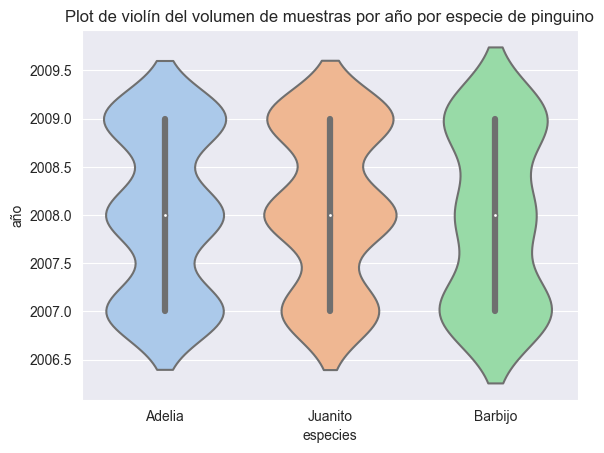

In [74]:
chart = sns.violinplot(data = pinguinos, x='especies', y='año', size=8,palette='pastel')
chart.set_title('Plot de violín del volumen de muestras por año por especie de pinguino')
plt.show()

# Predicción de la variable especies

Ahora que ya fue realizado un corto análisis y limpieza de los datos, comenzamos a preparar a estos para predecir la variable especie. Lo primero que se realiza es separar variables a predecir de las que van a formar parte de la predicción

In [75]:
le = preprocessing.LabelEncoder()

pinguinos['especies'] = le.fit_transform(pinguinos['especies'])

#Buscamos a que valor numérico corresponde cada especie : ['Adelia': 0, 'Barbijo': 1, 'Juanito': 2]
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

pinguinos['sexo'] = le.fit_transform(pinguinos['sexo'])
pinguinos['isla'] = le.fit_transform(pinguinos['isla'])

pinguinos.head()


{'Adelia': 0, 'Barbijo': 1, 'Juanito': 2}


,especies,isla,largo_pico,ancho_pico,largo_aleta,peso,sexo,año
0,0,2,39.1,18.7,181.0,3750.0,1,2007
1,0,2,39.5,17.4,186.0,3800.0,0,2007
2,0,2,40.3,18.0,195.0,3250.0,0,2007
3,0,2,40.3,18.0,195.0,3250.0,0,2007
4,0,2,36.7,19.3,193.0,3450.0,0,2007


In [76]:
#Se separan los datos en variable a predecir y variables que van a formar parte del modelo
X = pinguinos.drop('especies', axis=1)
Y = pinguinos['especies']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test = X_train.values, X_test.values
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Ahora que el modelo está entrenado vamos a ver las predicciones que es capaz de realizar

In [78]:
y_pred = rf.predict(X_test)

Evaluamos el modelo viendo la accuracy de las predicciones

In [79]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ',accuracy)

Accuracy:  1.0


Tenemos que el valor de accuracy del modelo es 1, por lo tanto las predicciones fueron exactas y se correspondieron a los valores del dataset de test en un 100%.
Por último inventamos a un pinguino y probamos el modelo para ver que especie brinda como respuesta.

In [80]:
#Definimos a nuestro nuevo pinguino
pinguImaginario = [[1, 42.0, 18.0, 191.0, 3800.0, 1, 2008]]

#Predecimos la especie del pinguino
pinguPred = rf.predict(pinguImaginario)
print(pinguPred)

[0]


El valor que nos devuelve el modelo está codificado, por lo tanto, buscamos a que especie corresponde el int 0 y obtenemos como respuesta que es un pinguino Adelia posiblente similar a el de la foto que se encuentra en el pie de esta notebook.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Hope_Bay-2016-Trinity_Peninsula%E2%80%93Ad%C3%A9lie_penguin_%28Pygoscelis_adeliae%29_04.jpg/375px-Hope_Bay-2016-Trinity_Peninsula%E2%80%93Ad%C3%A9lie_penguin_%28Pygoscelis_adeliae%29_04.jpg" alt="Pinguino Adelia parado sobre unas rocas mirando hacia el costado">